## Find Depth Spiral on a Pit

**Goal**: Visualize a set of snow depths around a pit

**Approach**: 

1. Grab an entry from the layers table associated to our pit site id 
2. Retrieve the pit location from the layer entry 
3. Build a circle around the pit location 
4. Request all the point data inside the circle 
5. Convert to a GeoDataFrame and plot


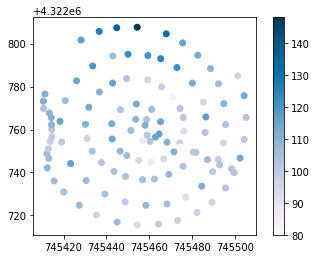

In [1]:
from snowxsql.db import get_db
from snowxsql.data import LayerData, PointData
from snowxsql.conversions import points_to_geopandas
import geoalchemy2.functions as gfunc
import geopandas as gpd

# PIT Site Identifier
site_id = '5S31'

# Distance around the pit to collect data in meters
buffer_dist = 50

# Connect to the database we made.
db_name = 'postgresql+psycopg2:///snowex'
engine, metadata, session = get_db(db_name)

# Grab our pit layers by site id
q = session.query(LayerData).filter(LayerData.site_id == site_id)
layers = q.all()

# Grab the pit location from a single layer
p = session.query(layers[0].geom.ST_AsText()).limit(1).all()

# Create a polygon buffered by our distance centered on the pit
q = session.query(gfunc.ST_Buffer(p[0][0], buffer_dist))
buffered_pit = q.all()[0][0]

# Grab all the point data in the buffer
points = session.query(PointData).filter(gfunc.ST_Within(PointData.geom.ST_AsText(), buffered_pit.ST_AsText())).all()
df = points_to_geopandas(points)
df.plot(column='value', legend=True, cmap='PuBu')

session.close()
